In [97]:
import random
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import glob
from PIL import Image
from scipy import stats
import pandas as pd
import json
from scipy.io import loadmat
import copy
import xlrd

from opts import *
from image_augmentations import *

from scipy.spatial.distance import euclidean
import json
import numpy as np
from fastdtw import fastdtw
import os
import cv2
import matplotlib.pyplot as plt
from  IPython.display import clear_output
import copy

In [18]:
def load_video(path, name, output_path, i):
        video_number = str(i).zfill(4)
        try:
            os.mkdir(output_path+name)
        except:
            print("duplicated")
        video  = cv2.VideoCapture(path)
        success = True
        count = 1
        while success:
            success, frame = video.read()
            if success:
                frame = cv2.resize(frame, (480,480), cv2.INTER_AREA)
                cv2.imwrite(output_path+name+"/"+name+"_{}".format(count) +".jpg", frame)
                count+=1
            else:
                break

In [19]:
path = "./OHP_Unlabeled/videos/"
output_path = "./OHP_Unlabeled/Imagenes/"

files = [f for f in os.listdir(path)]
files_sorted = sorted(files)  

for i, video in enumerate(files_sorted[:100]):
    name = video.split('.')[0]
    load_video(path+video, name, output_path, i+1)

In [102]:
class VideoDatasetSSL(Dataset):

    def __init__(self, path_bar_trayectory, input_path, output_path):
        super(VideoDatasetSSL, self).__init__()
        self.path_bar_trayectory = path_bar_trayectory
        self.input_path = input_path
        self.output_path = output_path
        self.trayectories = {}
        self.videos_files = []
        self.dtw_path = {}
        self.get_all_trayectories()

    def get_all_trayectories(self):
        files = [f for f in os.listdir(self.input_path)]
        files = sorted(files)  
        self.videos_files = files
        for file in files:
            name_ = file.split(".")[0]
            path = os.path.join(self.path_bar_trayectory, name_+".json")
            f = open(path)
            data = json.load(f) 
            trayectory_ = self.get_trayectory(data)
            self.trayectories[name_] = trayectory_

    def normalizar_posiciones_y(self, posiciones_y):
        pos_min = min(posiciones_y)
        pos_max = max(posiciones_y)
        amplitud_vertical = pos_max - pos_min

        if amplitud_vertical == 0:
            factor_escala = 1
        else:
            factor_escala = 1 / amplitud_vertical

        posiciones_y_normalizadas = np.array([[(pos - pos_min) * factor_escala] for pos in posiciones_y])
        return posiciones_y_normalizadas
    
    def get_trayectory(self, data):
        vertical_trayectory = np.zeros(len(data))
        trayectoria_normalizada = []
        for cnt, _ in enumerate(data):
            if len(data[cnt][0]) > 0:
                x1,y1,x2,y2,_ = data[cnt][0][0]
                center_x, center_y = int(x1 + (x2-x1)/2) , int(y1 + (y2 - y1)/2)
                vertical_trayectory[cnt] = center_y
            else:
                indices = np.nonzero(vertical_trayectory)[0]
                if len(indices) > 0:
                    j = indices[indices < cnt][-1]
                    value = vertical_trayectory[j]
                    vertical_trayectory[cnt] = value
        
        trayectoria_normalizada = self.normalizar_posiciones_y(vertical_trayectory)
        return trayectoria_normalizada
    
    def video_alignment(self, video1_embeddings, video2_embeddings):
        distance, path = fastdtw(video1_embeddings, video2_embeddings, dist=euclidean)
        return path, distance
    
    def find_lowest_point_index(self, y_trajectory):
        return np.argmin(y_trajectory)

    def split_trajectory(self, y_trajectory):
        lowest_point_index = self.find_lowest_point_index(y_trajectory)
        first_half = y_trajectory[:lowest_point_index]
        second_half = y_trajectory[lowest_point_index:]
        return first_half, second_half

    def plot_sync_videos(self, path, frames):
        for i,j in path:
            frame1 = frames[i]
            frame2 = frames[len(frames)-j-1]
            frame3 = self.add_agumentations(copy.deepcopy(frame1))
            frame = np.hstack((frame1, frame2, frame3))
            clear_output(wait=True)
            plt.imshow(frame)
            plt.show()

    def add_agumentations(self, frame):
        frame_np = np.array(frame)
        frame = Image.fromarray(frame_np)
        frame = hori_flip(frame)
        frame = masking(frame, type='random', mask_amt=0.5)
        frame = masking_checker_ol(frame)
        frame = masking_checker_nool(frame)
        return frame

    def __getitem__(self, idx):
        video_name = self.videos_files[idx]
        name_ = video_name.split('.')[0]
        path = os.path.join(self.input_path, video_name)
        
        trajectory = self.trayectories[name_]
        images = os.listdir(path)
        images.sort(key=lambda x: int(x.split("_")[2].split(".")[0]))
        frames = []
        for image in images:
            frame = cv2.imread(path+"/"+image, cv2.COLOR_BGR2RGB)
            frames.append(frame)

        first_half, second_half = self.split_trajectory(trajectory)
        second_half = np.flip(second_half)
        path, cost = self.video_alignment(first_half,second_half)
        self.plot_sync_videos(path, frames)


In [103]:
root_dir = "./ssl_triplets_dataset_ohp/"
transform = transforms.Compose([
    transforms.Resize(320),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

path_bar_trayectory = "./OHP_Unlabeled/bar_trajectories_raw/"
input_path = "./OHP_Unlabeled/Imagenes/"

SSL_dataset = VideoDatasetSSL(path_bar_trayectory, input_path, output_path="")

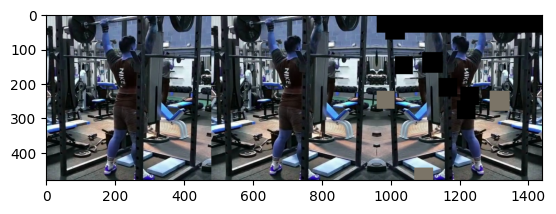

In [104]:
SSL_dataset.__getitem__(90)